In [24]:
#necessary modules
import pandas as pd
import numpy as np
import os
import nltk
import seaborn as sns
import re

from collections import Counter

from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report, accuracy_score

In [2]:
#configurations
DATA_DIR = 'data'
DATA_TRAIN = 'train.csv'
DATA_TEST = 'test.csv'
DATA_SEP = ','
DATA_NA = 'Not Available'
OUTPUT_FILE = 'submission.csv'

In [3]:
#read training dataset
df = pd.read_csv(os.path.join(DATA_DIR, DATA_TRAIN), sep=DATA_SEP, na_values=DATA_NA)

In [4]:
#inspect dataset
df.head()

Id  Category  \
0  635769805279248384  negative   
1  635930169241374720   neutral   
2  635950258682523648   neutral   
3  636030803433009153  negative   
4  636100906224848896  positive   

                                               Tweet  
0                                                NaN  
1  IOS 9 App Transport Security. Mm need to check...  
2  Mar if you have an iOS device, you should down...  
3  @jimmie_vanagon my phone does not run on lates...  
4  Not sure how to start your publication on iOS?...

In [5]:
#check # of entries
df.shape

(5970, 3)

In [6]:
#check # of missing values
df.isna().sum()

Id            0
Category      0
Tweet       548
dtype: int64

In [7]:
#drop missing values
df = df.dropna()
df.shape, df.isna().sum()

((5422, 3), Id          0
 Category    0
 Tweet       0
 dtype: int64)

In [8]:
df.groupby('Category').count()

Id  Tweet
Category             
Tweet        1      1
negative   869    869
neutral   1953   1953
positive  2599   2599

In [9]:
df = df[df['Category'] != 'Tweet']
df.groupby('Category').count()

Id  Tweet
Category             
negative   869    869
neutral   1953   1953
positive  2599   2599

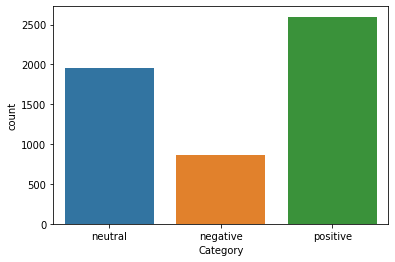

In [10]:
sns.countplot(x='Category', data = df)

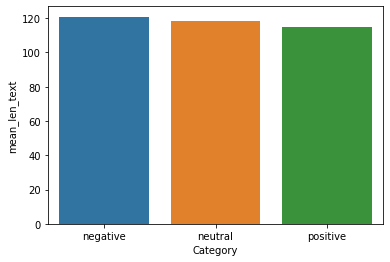

In [11]:
tmp_df = df.groupby('Category')['Tweet'].apply(lambda x: np.mean(x.str.len())).reset_index(name='mean_len_text')
sns.barplot(x='Category', y='mean_len_text', data=tmp_df)

In [157]:
class Tokenizer():
    def tokenize(self, text):
        smile_emoji_pattern = r'''(?x)
            (?::\)+)|
            (?::\ \)+)|
            (?::d+)|
            (?::-\)+)|
            (?:\(+-?:)|
            (?:;\)+)|
            (?:;\ \)+)|
            (?:;d+)|
            (?:;-\)+)|
            (?:\(+-?;)|
            (?:=d+)|
            (?:=\)+)
        '''
        
        sad_emoji_pattern = r'''(?x)
            (?::\(+)|
            (?::\ \(+)|
            (?:=\(+)|
            (?::-\(+)|
            (?:\)+-?:)
        '''
        
        pattern = r'''(?x)
                 (?:[A-Z]\.)+
                |\d+:\d  
                |(?:https?://)?(?:\w+\.)(?:\w{2,})+(?:[\w/]+) 
                |[@\#]?\w+(?:[-']\w+)*  
                |\$\d+(?:\.\d+)?%? 
                |\.\.\. 
                |[!?]+  
                (?::\)+)|
                (?::\ \)+)|
                (?::d+)|
                (?::-\)+)|
                (?:\(+-?:)|
                (?:;\)+)|
                (?:;\ \)+)|
                (?:;d+)|
                (?:;-\)+)|
                (?:\(+-?;)|
                (?:=d+)|
                (?:=\)+)|
                (?::\(+)|
                (?::\ \(+)|
                (?:=\(+)|
                (?::-\(+)|
                (?:\)+-?:)
        '''
        tokens = nltk.regexp_tokenize(text, pattern) #or tweeter Tokenizer 
        lemmatizer = nltk.WordNetLemmatizer()
        lem_tokens = []
        for token in tokens:
            if token.startswith('@'):
                lem_token = 'USERNAME'
            elif token.startswith('http'):
                lem_token = 'URL'
            elif re.match(smile_emoji_pattern, token):
                lem_token = ':)'
            elif re.match(sad_emoji_pattern, token):
                lem_token = ':('
            else: 
                lem_token = lemmatizer.lemmatize(token)
            lem_tokens.append(lem_token)
        return lem_tokens
    
class TextNormalizer():
    @staticmethod
    def normalize(text):
        text = text.strip().lower()
        text = text.replace('&nbsp;', ' ')
        text = text.replace('&lt;', '<')
        text = text.replace('&gt;', '>')
        text = text.replace('&amp;', '&')
        text = text.replace('&pound;', u'£')
        text = text.replace('&euro;', u'€')
        text = text.replace('&copy;', u'©')
        text = text.replace('&reg;', u'®')
        return text
    
def create_bow(tweets, features, tokenizer):
    row = []
    col = []
    data = []

    for i, tweet in enumerate(tweets):
        norm_tweet = TextNormalizer.normalize(tweet)
        tweet_tokens = tokenizer.tokenize(norm_tweet)

        for token in set(tweet_tokens):
            if token not in features:
                continue
            row.append(i)
            col.append(features[token])
            data.append(1)
    return csr_matrix((data, (row, col)), shape=(len(tweets), len(features)))

In [158]:
test = ":) :-) :))) =) :d =d  =) =)) : ) :ddd =ddd :-)) (: ((-: ;) ;-) ;)) ;d ;dd (; :( :-( ): )-: ))-:"
test = "May @dfind Itself Relying on Success of Tsipras's Greece  a http://t.co/k0O2I5WEof :) ) asda :)"
tokenizer = Tokenizer()
tokenizer.tokenize(test)

['May',
 'USERNAME',
 'Itself',
 'Relying',
 'on',
 'Success',
 'of',
 "Tsipras's",
 'Greece',
 'a',
 'URL',
 'asda']

In [159]:
words = Counter()
tweets = df['Tweet']
tokenizer = Tokenizer()

for tweet in tweets:
    norm_tweet = TextNormalizer.normalize(tweet)
    tokens = tokenizer.tokenize(norm_tweet)
    words.update(tokens)
words

Counter({'io': 97,
         '9': 37,
         'app': 31,
         'transport': 2,
         'security': 6,
         'mm': 2,
         'need': 137,
         'to': 2497,
         'check': 48,
         'if': 376,
         'my': 667,
         '3rd': 213,
         'party': 101,
         'network': 10,
         'pod': 1,
         'support': 44,
         'it': 1088,
         'URL': 1913,
         'mar': 13,
         'you': 1010,
         'have': 631,
         'an': 220,
         'device': 24,
         'should': 106,
         'download': 11,
         'our': 106,
         'too': 85,
         'USERNAME': 2237,
         'phone': 84,
         'doe': 59,
         'not': 426,
         'run': 71,
         'on': 1582,
         'latest': 9,
         'which': 63,
         'may': 1037,
         'account': 13,
         'for': 1137,
         'problem': 24,
         'the': 4303,
         'other': 50,
         'day': 527,
         'time': 358,
         'wa': 489,
         'replaced': 2,
         'sure': 55,
 

In [160]:
min_word_count = 3
common_words = list([k for k, v in words.most_common() if v > min_word_count])
common_words = [word for word in common_words if word not in nltk.corpus.stopwords.words('english')]
feature_dict = {}

for word in common_words:
    feature_dict[word] = len(feature_dict)
feature_dict

{'USERNAME': 0,
 'URL': 1,
 'may': 2,
 '...': 3,
 'tomorrow': 4,
 'day': 5,
 'wa': 6,
 'time': 7,
 '1st': 8,
 'see': 9,
 "i'm": 10,
 'like': 11,
 'going': 12,
 'get': 13,
 'one': 14,
 'friday': 15,
 'new': 16,
 'u': 17,
 'sunday': 18,
 'ha': 19,
 'want': 20,
 '2': 21,
 'night': 22,
 'make': 23,
 '3rd': 24,
 'go': 25,
 '2nd': 26,
 'jurassic': 27,
 'know': 28,
 'world': 29,
 'monday': 30,
 'think': 31,
 'say': 32,
 'obama': 33,
 'trump': 34,
 'come': 35,
 'watch': 36,
 'today': 37,
 'saturday': 38,
 'back': 39,
 'good': 40,
 'still': 41,
 'sun': 42,
 '10': 43,
 'game': 44,
 'need': 45,
 'show': 46,
 "valentine's": 47,
 'first': 48,
 'would': 49,
 'got': 50,
 "can't": 51,
 'best': 52,
 'last': 53,
 'love': 54,
 'tuesday': 55,
 'star': 56,
 'window': 57,
 'iphone': 58,
 'thursday': 59,
 'look': 60,
 'right': 61,
 'jeb': 62,
 'tory': 63,
 'bush': 64,
 'labor': 65,
 'biden': 66,
 'war': 67,
 'wednesday': 68,
 'park': 69,
 'lexus': 70,
 'joe': 71,
 'next': 72,
 'wood': 73,
 'tiger': 74,
 'tom

In [191]:
X_train, X_test, y_train, y_test = train_test_split(df['Tweet'], df['Category'], 
                                                    test_size=0.33, random_state=42)

print("Training classifier...")
X_train = create_bow(X_train, feature_dict, tokenizer)
labels = list(set(y_train))
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

print("Testing...")
X_test = create_bow(X_test, feature_dict, tokenizer)
predicted = classifier.predict(X_test)

print("=================== Results ===================")
print("            Positive    Neutral     Negative   ")
print("F1       ", f1_score(y_test, predicted, average=None, pos_label=None, labels=labels))
print("Precision", precision_score(y_test, predicted, average=None, pos_label=None, labels=labels))
print("Recall   ", recall_score(y_test, predicted, average=None, pos_label=None, labels=labels))
print("Accuracy ", accuracy_score(y_test, predicted))
print(labels)
print(confusion_matrix(y_test, predicted, labels=labels))


Training classifier...
Testing...
=================== Results ===================
            Positive    Neutral     Negative   
F1        [0.699101   0.39207921 0.44670051]
Precision [0.64995084 0.46046512 0.47396768]
Recall    [0.75629291 0.34137931 0.4224    ]
Accuracy  0.5723868082727781
['positive', 'negative', 'neutral']
[[661  34 179]
 [ 77  99 114]
 [279  82 264]]


In [119]:
X_train, X_test, y_train, y_test = train_test_split(df['Tweet'], df['Category'], 
                                                    test_size=0.33, random_state=42)

print("Training classifier...")
X_train = create_bow(X_train, feature_dict, tokenizer)
labels = list(set(y_train))
classifier = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=23)
classifier.fit(X_train, y_train)

print("Testing...")
X_test = create_bow(X_test, feature_dict, tokenizer)
predicted = classifier.predict(X_test)

print("=================== Results ===================")
print("            Positive    Neutral     Negative   ")
print("F1       ", f1_score(y_test, predicted, average=None, pos_label=None, labels=labels))
print("Precision", precision_score(y_test, predicted, average=None, pos_label=None, labels=labels))
print("Recall   ", recall_score(y_test, predicted, average=None, pos_label=None, labels=labels))
print("Accuracy ", accuracy_score(y_test, predicted))
print(confusion_matrix(y_test, predicted, labels=labels))


Training classifier...
Testing...
=================== Results ===================
            Positive    Neutral     Negative   
F1        [0.69482152 0.18965517 0.46253022]
Precision [0.61973094 0.56896552 0.46590909]
Recall    [0.79061785 0.1137931  0.4592    ]
Accuracy  0.5651201788708776
[[691  11 172]
 [100  33 157]
 [324  14 287]]


In [171]:
X_train, X_test, y_train, y_test = train_test_split(df['Tweet'], df['Category'], 
                                                    test_size=0.33, random_state=42)
print("Training classifier...")
X_train = create_bow(X_train, feature_dict, tokenizer)
labels = list(set(y_train))
classifier = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
classifier.fit(X_train, y_train)

print("Testing...")
X_test = create_bow(X_test, feature_dict, tokenizer)
predicted = classifier.predict(X_test)

print("=================== Results ===================")
print("            Positive    Neutral     Negative   ")
print("F1       ", f1_score(y_test, predicted, average=None, pos_label=None, labels=labels))
print("Precision", precision_score(y_test, predicted, average=None, pos_label=None, labels=labels))
print("Recall   ", recall_score(y_test, predicted, average=None, pos_label=None, labels=labels))
print("Accuracy ", accuracy_score(y_test, predicted))
print(confusion_matrix(y_test, predicted, labels=labels))


Training classifier...
Testing...
=================== Results ===================
            Positive    Neutral     Negative   
F1        [0.40184332 0.70073665 0.09968847]
Precision [0.47391304 0.58628659 0.51612903]
Recall    [0.3488     0.87070938 0.05517241]
Accuracy  0.5561766349916154
[[218 398   9]
 [107 761   6]
 [135 139  16]]


In [120]:
df_test = pd.read_csv(os.path.join(DATA_DIR, DATA_TEST), sep=DATA_SEP, dtype={"Id": object})
df_test.shape

(9968, 2)

In [121]:
df_test = df_test.dropna()
df_test.shape

(4000, 2)

In [189]:
#selected clasiffier
classifier = MultinomialNB()
tokenizer = nltk.TweetTokenizer()
X_full = classifier.fit(create_bow(df['Tweet'], feature_dict, tokenizer), df['Category'])
X_test = create_bow(df_test['Tweet'], feature_dict, tokenizer)
predicted = classifier.predict(X_test)
df_test['Category'] = predicted
df_test[['Id', 'Category']].to_csv(OUTPUT_FILE, sep=DATA_SEP, index=False)
df_test[['Id', 'Category']]

Id  Category
0     628949369883000832   neutral
1     628976607420645377   neutral
2     629023169169518592  positive
3     629179223232479232  positive
4     629186282179153920  positive
5     629226490152914944   neutral
6     629345637155360768   neutral
7     629394528336637953   neutral
8     629650766580609026  positive
9     629797991826722816  negative
10    630159517058142208  positive
11    630542330827771904   neutral
12    630636736746422272  negative
13    630807124872970240  negative
14    630818265799921664  positive
15    630909171437801472  positive
16    630982270409572352   neutral
17    631104156187627520  positive
18    631223085476261890  negative
19    631368262979297281  negative
20    631521079245307904  positive
21    631543121407442946  negative
22    631696872323850240  positive
23    631792365590695936  positive
24    631842974268305408  positive
25    631843393971204097  positive
26    631936716522278912   neutral
27    632374683334258688   neutral
28    632536348419690496  positive
29    632805868334153728  negative
...                  ...       ...
3970  639287851725619200  positive
3971  639319688070086656  positive
3972  639431507363414016   neutral
3973  639564269420331008  positive
3974  639639485207019520  positive
3975  639645064633823233  positive
3976  639666970229473280  positive
3977  639808591529033729  positive
3978  639821082497818625  positive
3979  640020822313304064  positive
3980  640173861078626304   neutral
3981  640212997596549120  positive
3982  640475498137518080   neutral
3983  640477314023723010  positive
3984  640689013788176384  positive
3985  640704945134661636  positive
3986  640705879520636928   neutral
3987  640728268254019584  positive
3988  640731830300340224  positive
3989  640758594959450112  positive
3990  641064131706122240  positive
3991  641087370872422401  positive
3992  641089872426631168   neutral
3993  641254971401502720  positive
3994  641371402348679168  positive
3995  641411385700712448  positive
3996  641452712098406400  positive
3997  635369700298498048   neutral
3998  635769805279248384  positive
3999  635930169241374720   neutral

[4000 rows x 2 columns]